# FRQI in Qiskit

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math
from ibm_washington_config import coupling_map, basis_gates
#from ionq_config import coupling_map, basis_gates

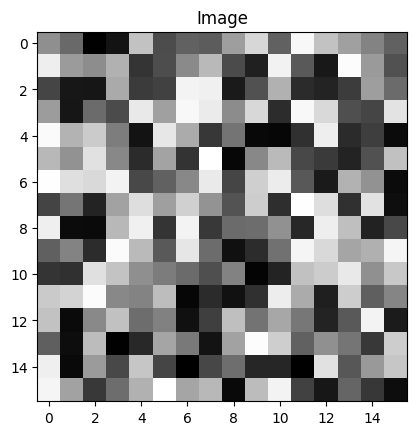

In [2]:
image = np.random.uniform(low=0, high=255, size=(16,16)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [10]:
image

array([[142, 106,   1,  19, 193,  76,  97,  92, 157, 214,  97, 247, 193,
        159, 131,  98],
       [237, 154, 140, 176,  52,  77, 137, 184,  75,  32, 241,  89,  24,
        251, 153,  82],
       [ 69,  23,  22, 169,  59,  66, 243, 239,  26,  82, 176,  43,  35,
         60, 157, 107],
       [155,  22, 107,  75, 232, 159, 247, 234, 139, 215,  44, 247, 216,
         79,  69, 226],
       [249, 179, 202, 125,  19, 230, 170,  55, 116,   8,   6,  48, 237,
         43,  62,  11],
       [183, 145, 224, 135,  43, 163,  51, 254,   7, 135, 185,  72,  58,
         35,  82, 192],
       [253, 222, 216, 242,  72,  98, 135, 233,  69, 206, 235,  88,  26,
        177, 145,  11],
       [ 68, 117,  35, 161, 221, 158, 207, 147,  83, 204,  46, 253, 221,
         48, 225,  14],
       [238,  11,  10, 183, 239,  53, 242,  57, 107, 109, 144,  39, 237,
        190,  34,  72],
       [ 96, 130,  45, 250, 185,  90, 229, 108,  16,  45, 113, 244, 216,
        164, 175, 244],
       [ 53,  48, 223, 195, 14

In [3]:
input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

In [4]:
O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

C:\Users\HCI\AppData\Local\Temp\ipykernel_15688\2498201748.py:8: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


In [5]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 2274, # of qubits is 9


In [6]:
wash_qc = transpile(circuits=qc_image, coupling_map=coupling_map, basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))
# wash_qc.draw()

TranspilerError: 'Only a single input coupling map can be used with transpile() if you need to target different coupling maps for different circuits you must call transpile() multiple times'

In [7]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=20000)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)

C:\Users\HCI\AppData\Local\Temp\ipykernel_15688\4293248132.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


[134, 110, 0, 19, 186, 69, 107, 85, 160, 222, 99, 256, 208, 163, 138, 96, 237, 165, 134, 170, 41, 68, 131, 188, 59, 0, 228, 82, 20, 256, 144, 80, 88, 0, 27, 181, 56, 65, 256, 231, 38, 72, 179, 60, 34, 63, 162, 103, 133, 18, 89, 71, 234, 150, 256, 238, 137, 210, 33, 238, 214, 79, 57, 236, 256, 162, 214, 120, 18, 256, 179, 39, 110, 0, 0, 41, 237, 56, 51, 19, 197, 155, 235, 148, 30, 168, 60, 256, 0, 147, 181, 71, 48, 19, 78, 197, 256, 217, 220, 256, 69, 101, 126, 236, 58, 205, 256, 100, 26, 172, 158, 0, 64, 105, 26, 161, 228, 161, 200, 156, 97, 195, 48, 256, 229, 44, 224, 19, 237, 0, 0, 202, 236, 47, 226, 38, 100, 116, 131, 35, 256, 197, 39, 69, 100, 115, 40, 256, 184, 69, 237, 116, 18, 51, 81, 235, 210, 147, 170, 256, 43, 64, 224, 210, 128, 112, 92, 89, 118, 0, 25, 190, 205, 256, 131, 193, 196, 213, 256, 138, 127, 186, 0, 33, 19, 54, 256, 168, 19, 213, 92, 150, 184, 18, 129, 197, 114, 139, 0, 62, 189, 123, 171, 102, 35, 84, 256, 32, 73, 0, 172, 0, 54, 164, 118, 19, 172, 256, 204, 97, 142

In [8]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

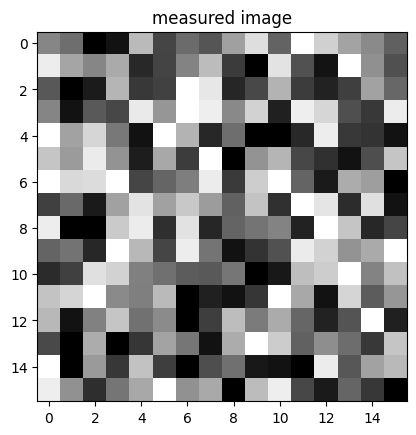

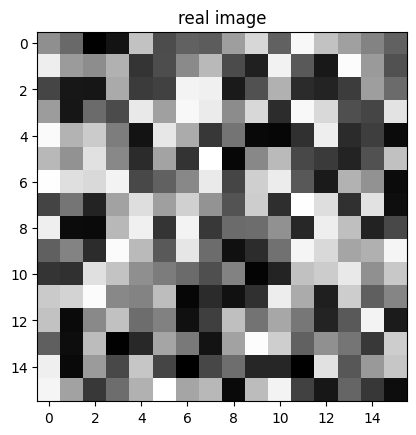

In [9]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

# In IonQ, Ours

In [2]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("API-KEY")

In [3]:
# Show all backends:
print(provider.backends())

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [4]:
# Get IonQ's simulator backend:
simulator_backend = provider.get_backend("ionq_simulator")

In [5]:
import os
import qiskit
import numpy as np
from PIL import Image
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector


In [7]:
def project(img, h_img, w_img, h_proj, w_proj):

    (row, col, _) = img
    x = row
    y = col
    z = 0
    print("x,y,z = ",x,y,z)
    r = 1
    Q = np.array([x, y, z], dtype=np.float32)
    X = get_2d_to_3d(Q,r)
    return X

def get_2d_to_3d(point,r):
    [x, y, _] = point
    k = round(4*r / (x**2 + y**2 + 4*r**2), 4)
    print("r = ", r, " k = ", k)
    k_list.append(k)
    P = np.array([k * x, k * y, (1-2*k)*r ])
    return P

In [8]:
os.path.abspath('')

'c:\\Users\\HCI\\Desktop\\Stereo'

In [10]:
path_img_2 = 'pixel2x2.png'
path_img_2 = os.path.join(os.path.abspath(''),
                            path_img_2)
print(path_img_2)

c:\Users\HCI\Desktop\Stereo\pixel2x2.png


In [11]:
pix = np.array(Image.open(path_img_2))

h_img = pix.shape[0]
w_img = pix.shape[1]
h_proj_2 = 2
w_proj_2 = 2

proj_2 = np.array([[1,1,0],
                 [-1,1,0],
                 [-1,-1,0],
                 [1,-1,0]])

point_2d = []
point_3d = []
k_list = []

for i in proj_2:
    sphere = project(i,h_img, w_img, h_proj_2, w_proj_2)
    point_2d.append(i)
    point_3d.append(sphere)
    
print('point_2d = ', point_2d)
print('point_3d = ', point_3d)
print("k = ", k_list)

x,y,z =  1 1 0
r =  1  k =  0.6667
x,y,z =  -1 1 0
r =  1  k =  0.6667
x,y,z =  -1 -1 0
r =  1  k =  0.6667
x,y,z =  1 -1 0
r =  1  k =  0.6667
point_2d =  [array([1, 1, 0]), array([-1,  1,  0]), array([-1, -1,  0]), array([ 1, -1,  0])]
point_3d =  [array([ 0.6667,  0.6667, -0.3334]), array([-0.6667,  0.6667, -0.3334]), array([-0.6667, -0.6667, -0.3334]), array([ 0.6667, -0.6667, -0.3334])]
k =  [0.6667, 0.6667, 0.6667, 0.6667]


[array([1, 1, 0]), array([-1,  1,  0]), array([-1, -1,  0]), array([ 1, -1,  0])]


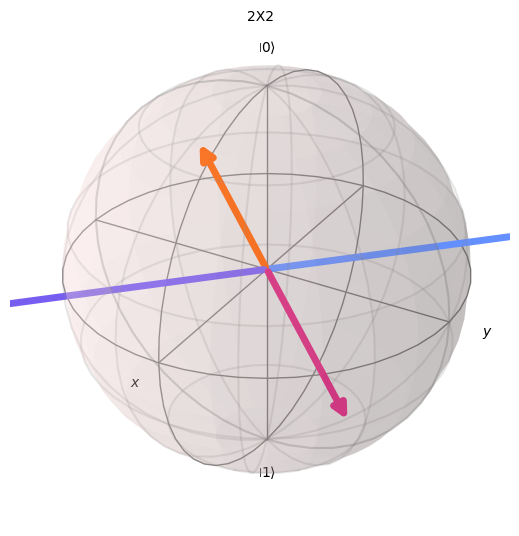

In [12]:
print(point_2d)
plot_bloch_vector(point_2d, title='2X2')

[array([ 0.6667,  0.6667, -0.3334]), array([-0.6667,  0.6667, -0.3334]), array([-0.6667, -0.6667, -0.3334]), array([ 0.6667, -0.6667, -0.3334])]


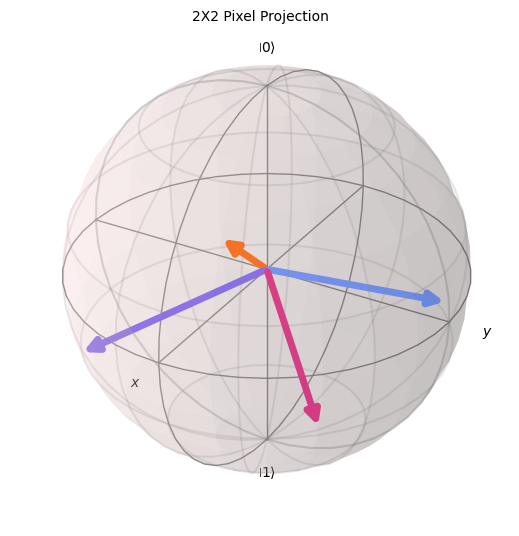

In [13]:
print(point_3d)
plot_bloch_vector(point_3d, title='2X2 Pixel Projection')

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


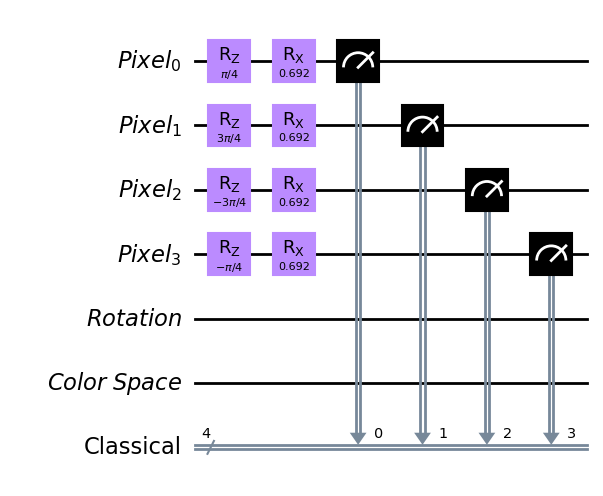

In [48]:
pixel = QuantumRegister(size=4, name='Pixel')
rotation = QuantumRegister(size=1, name='Rotation')
color = QuantumRegister(size=1,name="Color Space")
cla = ClassicalRegister(size=4,name="Classical")

qc = QuantumCircuit(pixel,rotation,color,cla)

for i in range(h_img**2):
    phi = np.arctan2(point_3d[i][1],point_3d[i][0])
    qc.rz(phi,i)

    Inner = np.dot(point_2d[i],point_3d[i])
    size = np.sqrt((point_2d[i][0]**2+point_2d[i][1]**2+point_2d[i][2]**2)
               +point_3d[i][0]**2+point_3d[i][1]**2+point_3d[i][2]**2)

    theta =  np.arccos(Inner / size)
    qc.rx(theta, i)

qc.measure(list(range(pixel.size)), list(range(cla.size)))
qc.draw('mpl')

In [111]:
# Run the circuit on IonQ's platform:
job = simulator_backend.run(qc, shots=10000) 

# Print the counts
print(job.get_counts())

{'0000': 6133, '0001': 789, '0010': 767, '0011': 99, '0100': 794, '0101': 107, '0110': 123, '0111': 5, '1000': 815, '1001': 117, '1010': 105, '1011': 14, '1100': 101, '1101': 13, '1110': 16, '1111': 2}


In [17]:
from qiskit import *

backend = BasicAer.get_backend('qasm_simulator') # the device to run on
result = execute(qc, backend, shots=1000).result()
counts  = result.get_counts(qc)
print(counts)

{'0000': 583, '1010': 15, '0100': 90, '0001': 78, '0010': 90, '1000': 91, '0011': 9, '0110': 9, '1001': 8, '0101': 7, '1100': 10, '1101': 4, '1011': 2, '0111': 2, '1110': 2}


In [21]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = execute(qc, backend).result()
psi  = result.get_statevector(qc)

In [67]:
print(job.get_probabilities())

{'0000': 0.613194316, '0001': 0.079750405, '0010': 0.079750405, '0011': 0.010372123, '0100': 0.079750405, '0101': 0.010372123, '0110': 0.010372123, '0111': 0.00134897, '1000': 0.079750405, '1001': 0.010372123, '1010': 0.010372123, '1011': 0.00134897, '1100': 0.010372123, '1101': 0.00134897, '1110': 0.00134897, '1111': 0.000175443}


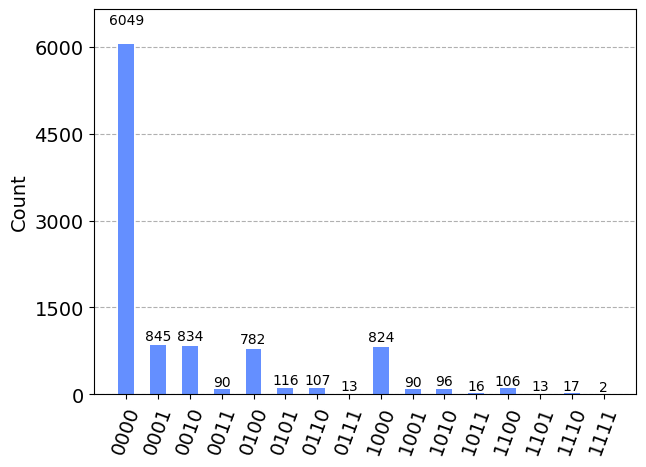

In [68]:
from qiskit.visualization import plot_histogram

plot_histogram(job.get_counts())

# FRQI in Qiskit

In [86]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit_aer.aerprovider import AerProvider
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math


from ibm_washington_config import coupling_map, basis_gates
#from ionq_config import coupling_map, basis_gates

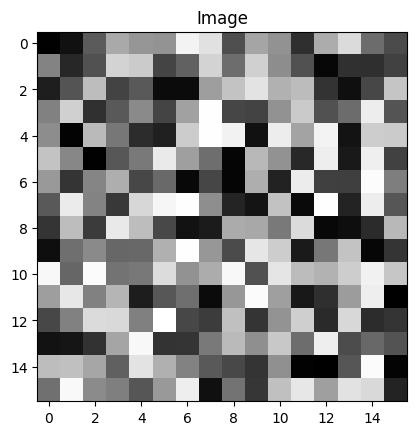

In [38]:
image = np.random.uniform(low=0, high=255, size=(16,16)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [87]:
image

array([[ 67, 240,  65,  43, 214,  98, 164,  82,  70, 233, 114, 228, 226,
         16, 193, 200],
       [149,  34, 103,  31, 120,  42,  46, 219,  22, 132, 212, 220, 220,
        176,  87, 149],
       [141,  71, 127, 147, 234,  45, 219, 239,  79, 167, 162, 116, 100,
         20, 228, 241],
       [217, 224, 246, 127,  46,  28,  64, 189, 124,  21, 155,   0,  22,
        195, 127,  30],
       [213, 147, 175, 213,  43, 118, 210, 115, 191,  70, 166, 164, 174,
         69, 239,  71],
       [ 84,  96, 156, 159, 254, 141, 241,  26, 179, 107,  97,  17, 215,
        125,  55, 100],
       [177, 165, 228, 124,  87,  86,   6,  70, 132,  97,  61, 118, 201,
        165, 142,  23],
       [197,  58, 152, 254, 198, 162, 107, 232, 229, 252,  59, 165,   1,
        150,  21, 116],
       [152, 164,  29,  32, 245,  90, 214,  68,  62,  21, 145,  37, 135,
         23,  83, 230],
       [179,  71, 162, 165,  23,   8, 207,  78, 194, 155, 241, 235, 191,
        171, 204,  47],
       [167, 197, 177, 139,  7

In [39]:
input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

In [40]:
O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

C:\Users\HCI\AppData\Local\Temp\ipykernel_15600\2468131786.py:8: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


In [41]:
controls_ = []

for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

In [42]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 2274, # of qubits is 9


In [43]:
wash_qc = transpile(circuits=qc_image)
print("depth is {}".format(wash_qc.depth()))
# wash_qc.draw()

depth is 2050


In [44]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=20000)
job_oqim = aer_sim.run(qobj)

result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()

C:\Users\HCI\AppData\Local\Temp\ipykernel_15600\4027200361.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


In [45]:
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)

[0, 26, 91, 168, 134, 146, 239, 219, 66, 155, 154, 18, 179, 229, 93, 74, 133, 44, 80, 216, 199, 62, 89, 216, 120, 193, 139, 78, 0, 58, 25, 53, 17, 77, 173, 68, 91, 0, 0, 155, 206, 221, 162, 185, 47, 0, 90, 201, 136, 194, 48, 95, 138, 75, 148, 256, 72, 77, 123, 213, 77, 109, 256, 88, 133, 0, 193, 121, 52, 31, 200, 256, 229, 0, 256, 161, 256, 19, 215, 190, 184, 133, 0, 87, 115, 229, 166, 105, 0, 179, 145, 36, 256, 0, 229, 68, 141, 57, 125, 170, 82, 119, 18, 64, 0, 186, 32, 219, 44, 47, 256, 114, 94, 256, 146, 59, 222, 256, 256, 145, 35, 17, 202, 0, 256, 35, 256, 68, 47, 188, 74, 224, 179, 69, 0, 21, 170, 169, 130, 228, 19, 26, 51, 189, 26, 125, 153, 92, 76, 192, 256, 142, 71, 222, 216, 19, 129, 177, 0, 52, 256, 107, 256, 99, 117, 218, 142, 184, 256, 82, 228, 192, 201, 201, 256, 199, 163, 230, 133, 182, 37, 73, 118, 0, 163, 256, 168, 0, 45, 150, 256, 0, 62, 137, 212, 216, 126, 256, 66, 72, 187, 42, 140, 200, 53, 223, 37, 57, 29, 32, 51, 163, 256, 55, 44, 118, 199, 165, 194, 100, 256, 74, 

In [46]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

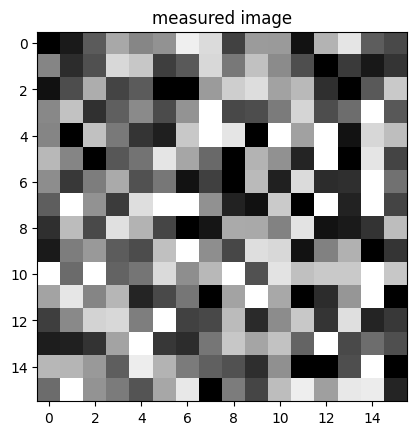

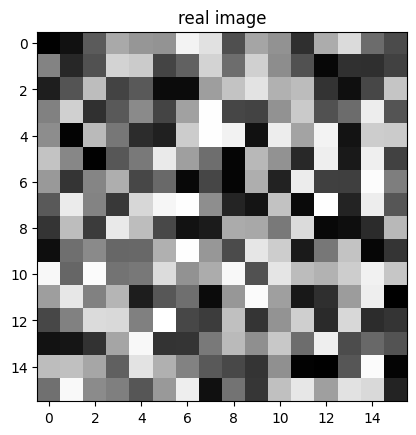

In [47]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

# FRQI in IonQ

In [23]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("API-KEY")

In [ ]:
image = np.random.uniform(low=0, high=255, size=(16,16)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [26]:
input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

In [27]:
O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

C:\Users\HCI\AppData\Local\Temp\ipykernel_15600\2468131786.py:8: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


In [28]:
controls_ = []

for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

In [29]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 2274, # of qubits is 9


In [30]:
wash_qc = transpile(circuits=qc_image)
print("depth is {}".format(wash_qc.depth()))
# wash_qc.draw()

depth is 2050


In [31]:
simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
job_oqim = simulator_backend.run(t_qc_image)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()

In [35]:
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        classical_colors.append(0)
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)

[68, 170, 100, 256, 256, 256, 256, 256, 0, 128, 175, 0, 100, 256, 256, 128, 0, 256, 256, 128, 0, 0, 256, 91, 0, 256, 0, 187, 256, 256, 128, 0, 187, 0, 0, 0, 0, 0, 128, 256, 256, 0, 256, 0, 256, 128, 0, 0, 128, 0, 256, 170, 75, 0, 155, 100, 75, 0, 0, 0, 100, 155, 63, 0, 0, 256, 100, 170, 256, 0, 155, 256, 0, 0, 128, 139, 256, 0, 100, 144, 180, 170, 0, 155, 118, 128, 256, 187, 0, 256, 100, 256, 0, 0, 0, 256, 256, 256, 187, 256, 256, 128, 0, 0, 170, 75, 187, 128, 0, 0, 155, 256, 155, 0, 256, 256, 256, 256, 256, 256, 0, 75, 0, 256, 155, 256, 85, 256, 75, 170, 0, 0, 0, 111, 0, 0, 128, 75, 256, 128, 256, 85, 0, 144, 144, 58, 256, 0, 170, 0, 0, 85, 256, 256, 0, 256, 256, 256, 0, 85, 192, 0, 256, 0, 256, 0, 0, 85, 100, 0, 128, 155, 144, 256, 256, 128, 128, 0, 256, 75, 256, 256, 0, 0, 0, 0, 85, 256, 256, 0, 100, 0, 256, 75, 0, 256, 256, 63, 100, 75, 100, 256, 0, 128, 0, 128, 144, 170, 0, 155, 0, 256, 144, 0, 128, 116, 256, 256, 256, 256, 128, 256, 170, 128, 170, 0, 63, 0, 256, 0, 256, 0, 0, 256

In [36]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

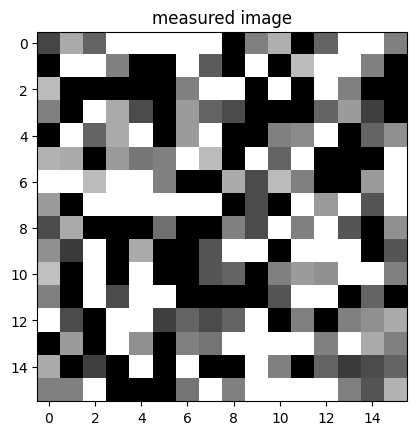

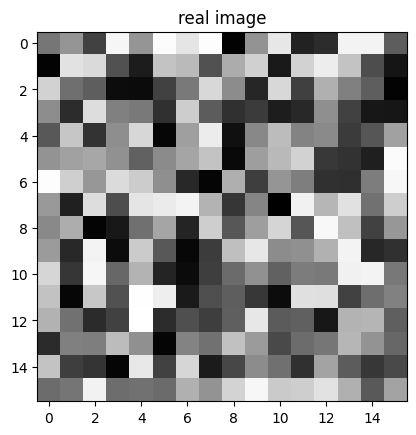

In [37]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)